# Bayesian calibration of the flooding model

The goal of this example is to present the Bayesian calibration of the flooding model.

## Model

The simulator predicts the water height H depending on the flowrate Q.

We consider the following four variable:

* Q : the river flowrate ($m^3/s$)
* Ks : the Strickler coefficient ($m^{1/3}/s$)
* Zv : the downstream riverbed level (m)
* Zm : the upstream riverbed level (m)

When the Strickler coefficient increases, the riverbed generates less friction to the water flow.

## Parameters

We consider the following parameters:

* the length of the river L = 5000 (m),
* the width of the river B = 300 (m).

## Outputs

We make the hypothesis that the slope of the river is nonpositive and close to zero, which implies:
$$
\alpha = \frac{Z_m - Z_v}{L},
$$

if $Z_m \geq Z_v$. 
The height of the river is:
$$
H = \left(\frac{Q}{K_s B \sqrt{\alpha}}\right)^{0.6},
$$

for any $K_s, Q>0$.

## Distribution

We assume that the river flowrate has the following truncated Gumbel distribution:

|Variable|Distribution|
| ------------- |-------------|
|Q|Gumbel(scale=558, mode=1013)>0|

## Parameters to calibrate

The vector of parameters to calibrate is:
$$
\theta = (K_s,Z_v,Z_m).
$$

The variables to calibrate are $(K_s,Z_v,Z_m)$ and are set to the following values:
$$
K_s = 30, \qquad Z_v = 50, \qquad Z_m = 55.
$$

## Observations

In this section, we describe the statistical model associated with the $n$ observations.
The errors of the water heights are associated with a gaussian distribution with a zero mean and a standard variation equal to:
$$
\sigma=0.1.
$$

Therefore, the observed water heights are:
$$
H_i = G(Q_i,K_s,Z_v,Z_m) + \epsilon_i
$$

for $i=1,...,n$ where
$$
\epsilon \sim \mathcal{N}(0,\sigma^2)
$$

and we make the hypothesis that the observation errors are independent.
We consider a sample size equal to:

$$
n=20.
$$

The observations are the couples $\{(Q_i,H_i)\}_{i=1,...,n}$, i.e. each observation is a couple made of the flowrate and the corresponding river height.

## Variables

* Q : Input. Observed.
* Ks, Zv, Zm : Input. Calibrated.
* H: Output. Observed.

In this model, the variables $Z_m$ and $Z_v$ are not identifiables, since only the difference $Z_m-Z_v$ matters. Hence, calibrating this model requires some regularization.

## Generate the observations

In [1]:
import numpy as np
import openturns as ot

We define the model $g$ which has 4 inputs and one output H.

The nonlinear least squares does not take into account for bounds in the parameters. Therefore, we ensure that the output is computed whatever the inputs. The model fails into two situations:

* if $K_s<0$,
* if $Z_v-Z_m<0$.

In these cases, we return an infinite number.

In [2]:
def functionFlooding(X) :
    L = 5.0e3
    B = 300.0
    Q, K_s, Z_v, Z_m = X
    alpha = (Z_m - Z_v)/L
    if alpha < 0.0 or K_s <= 0.0:
        H = np.inf
    else:
        H = (Q/(K_s*B*np.sqrt(alpha)))**(3.0/5.0)
    return [H]

In [3]:
g = ot.PythonFunction(4, 1, functionFlooding) 
g = ot.MemoizeFunction(g)
g.setOutputDescription(["H (m)"])

Create the input distribution for $Q$.

In [4]:
Q = ot.Gumbel(558.0, 1013.0)
Q = ot.TruncatedDistribution(Q,ot.TruncatedDistribution.LOWER)
Q.setDescription(["Q (m3/s)"])
Q

class=TruncatedDistribution name=TruncatedDistribution distribution=class=ParametrizedDistribution parameters=class=GumbelAB name=Unnamed a=1013 b=558 distribution=class=Gumbel name=Gumbel dimension=1 alpha=0.00179211 beta=1013 bounds=class=Interval name=Unnamed dimension=1 lower bound=class=Point name=Unnamed dimension=1 values=[0] upper bound=class=Point name=Unnamed dimension=1 values=[19000.8] finite lower bound=[1] finite upper bound=[0] thresholdRealization=0.5

Set the parameters to be calibrated.

In [5]:
K_s = ot.Dirac(30.0)
Z_v = ot.Dirac(50.0)
Z_m = ot.Dirac(55.0)
K_s.setDescription(["Ks (m^(1/3)/s)"])
Z_v.setDescription(["Zv (m)"])
Z_m.setDescription(["Zm (m)"])

Create the joint input distribution.

In [6]:
inputRandomVector = ot.ComposedDistribution([Q, K_s, Z_v, Z_m])

Create a Monte-Carlo sample of the output H.

In [7]:
nbobs = 20
inputSample = inputRandomVector.getSample(nbobs)
outputH = g(inputSample)

Generate the observation noise and add it to the output of the model.

In [8]:
sigmaObservationNoiseH = 0.1 # (m)
noiseH = ot.Normal(0.,sigmaObservationNoiseH)
ot.RandomGenerator.SetSeed(0)
sampleNoiseH = noiseH.getSample(nbobs)
Hobs = outputH + sampleNoiseH

Plot the Y observations versus the X observations.

In [9]:
Qobs = inputSample[:,0]

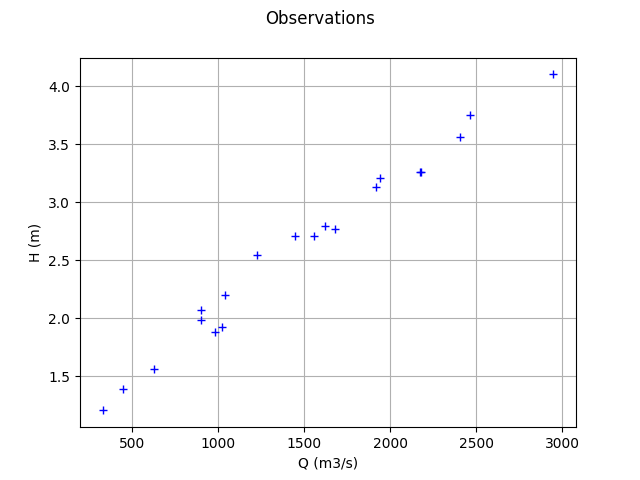

In [10]:
graph = ot.Graph("Observations","Q (m3/s)","H (m)",True)
cloud = ot.Cloud(Qobs,Hobs)
graph.add(cloud)
graph

## Setting the calibration parameters

Define the parametric model $z = f(x,\theta)$ that associates each observation $x_i$ and values of the  parameters $\theta_i$ to the parameters of the distribution of the corresponding observation: here $z=(\mu, \sigma)$

In [11]:
def fullModelPy(X):
    Q, K_s, Z_v, Z_m = X
    H = g(X)[0]
    sigmaH = 0.5 # (m^2) The standard deviation of the observation error.
    return [H,sigmaH]

fullModel = ot.PythonFunction(4, 2, fullModelPy)
model = ot.ParametricFunction(fullModel, [0], Qobs[0])
model

class=FunctionImplementation name=Unnamed description=[x1,x2,x3,y0,y1] evaluationImplementation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0,y1] evaluationImplementation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0,y1] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0,y1] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0,y1] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[0] parameters=class=PointWithDescription name=Unnamed dimension=1 description=[x0] values=[1443.6] input positions=[1,2,3] gradientImplementation=class=ParametricGradient evaluation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0,y1] evaluationImplementation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0,y1] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0,y1] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0,y1] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[0] parameters=class=PointWithDescription name=Unnamed dimension=1 description=[x0] values=[1443.6] input positions=[1,2,3] hessianImplementation=class=ParametricHessian evaluation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0,y1] evaluationImplementation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0,y1] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0,y1] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0,y1] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[0] parameters=class=PointWithDescription name=Unnamed dimension=1 description=[x0] values=[1443.6] input positions=[1,2,3]

Define the value of the reference values of the $\theta$ parameter. In the bayesian framework, this is called the mean of the *prior* gaussian distribution. In the data assimilation framework, this is called the *background*.

In [12]:
KsInitial = 20.
ZvInitial = 49.
ZmInitial = 51.
parameterPriorMean = ot.Point([KsInitial,ZvInitial,ZmInitial])
paramDim = parameterPriorMean.getDimension()

Define the covariance matrix of the parameters $\theta$ to calibrate.

In [13]:
sigmaKs = 5.
sigmaZv = 1.
sigmaZm = 1.

In [14]:
parameterPriorCovariance = ot.CovarianceMatrix(paramDim)
parameterPriorCovariance[0,0] = sigmaKs**2
parameterPriorCovariance[1,1] = sigmaZv**2
parameterPriorCovariance[2,2] = sigmaZm**2
parameterPriorCovariance

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[25,0,0,0,1,0,0,0,1]

Define the the prior distribution $\pi(\underline{\theta})$ of the parameter $\underline{\theta}$

In [15]:
prior = ot.Normal(parameterPriorMean,parameterPriorCovariance)
prior.setDescription(['Ks', 'Zv', 'Zm'])
prior

class=Normal name=Normal dimension=3 mean=class=Point name=Unnamed dimension=3 values=[20,49,51] sigma=class=Point name=Unnamed dimension=3 values=[5,1,1] correlationMatrix=class=CorrelationMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1,0,0,0,1,0,0,0,1]

Define the distribution of observations $\underline{y} | \underline{z}$ conditional on model predictions. 

Note that its parameter dimension is the one of $\underline{z}$, so the model must be adjusted accordingly. In other words, the input argument of the `setParameter` method of the conditional distribution must be equal to the dimension of the output of the `model`. Hence, we do not have to set the actual parameters: only the type of distribution is used.

In [16]:
conditional = ot.Normal()
conditional

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

Proposal distribution: uniform.

In [17]:
proposal = [ot.Uniform(-5., 5.),ot.Uniform(-1., 1.),ot.Uniform(-1., 1.)]
proposal

[class=Uniform name=Uniform dimension=1 a=-5 b=5,
 class=Uniform name=Uniform dimension=1 a=-1 b=1,
 class=Uniform name=Uniform dimension=1 a=-1 b=1]

## Test the MCMC sampler

The MCMC sampler essentially computes the log-likelihood of the parameters.

In [18]:
mymcmc = ot.MCMC(prior, conditional, model, Qobs, Hobs, parameterPriorMean)

In [19]:
mymcmc.computeLogLikelihood(parameterPriorMean)

-150.5368575399012

## Test the Metropolis-Hastings sampler

- Creation of the Random Walk Metropolis-Hastings (RWMH) sampler.

In [20]:
initialState = parameterPriorMean

In [21]:
RWMHsampler = ot.RandomWalkMetropolisHastings(
    prior, conditional, model, Qobs, Hobs, initialState, proposal)

Tuning of the RWMH algorithm.

Strategy of calibration for the random walk (trivial example: default).

In [22]:
strategy = ot.CalibrationStrategyCollection(paramDim)
RWMHsampler.setCalibrationStrategyPerComponent(strategy)

Other parameters.

In [23]:
RWMHsampler.setVerbose(True)
RWMHsampler.setThinning(1)
RWMHsampler.setBurnIn(200)

Generate a sample from the posterior distribution of the parameters theta.

In [24]:
sampleSize = 1000
sample = RWMHsampler.getSample(sampleSize)

Look at the acceptance rate (basic checking of the efficiency of the tuning; value close to 0.2 usually recommended).

In [25]:
RWMHsampler.getAcceptanceRate()

class=Point name=Unnamed dimension=3 values=[0.5175,0.608333,0.6025]

Build the distribution of the posterior by kernel smoothing.

In [26]:
kernel = ot.KernelSmoothing()
posterior = kernel.build(sample)

Display prior vs posterior for each parameter.

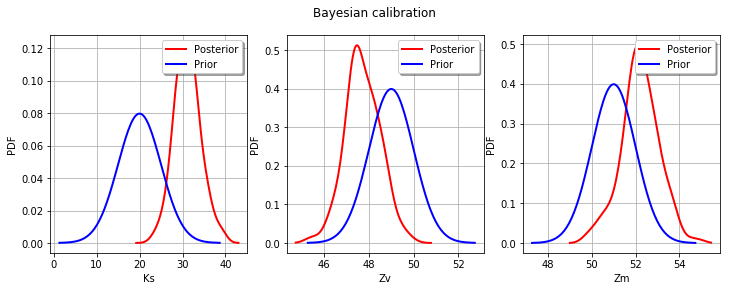

In [27]:
from openturns.viewer import View
import pylab as pl

fig = pl.figure(figsize=(12, 4))

for parameter_index in range(paramDim):
    graph = posterior.getMarginal(parameter_index).drawPDF()
    priorGraph = prior.getMarginal(parameter_index).drawPDF()
    priorGraph.setColors(['blue'])
    graph.add(priorGraph)
    graph.setLegends(['Posterior', 'Prior'])
    ax = fig.add_subplot(1, paramDim, parameter_index+1)
    _ = ot.viewer.View(graph, figure=fig, axes=[ax])

_ = fig.suptitle("Bayesian calibration")